### Your name:

<pre></pre>

### Collaborators:

<pre></pre>


In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.utils.fixes import signature
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Classification

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember appendix B
- Study the ROC Curve, decide threshold
- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {3, 4, 6, 7, 10, 20, 50, 100} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 4, 5, 7, 10, 20, 50} 
    - Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Cross-validation with 4-folds.

- Other parameters -> Use default

Notes:
  - Make your code modular, the second part of the assignment you will have to repeat. 
  - Include documentation for your code 

In [3]:
df = pd.read_excel("./datasets/default_of_credit_card_clients.xls", sheet = 0, skiprows= 1, header = 0)

## Data Investigation

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
columns = df.columns
traget_column = 'default payment next month'

Check for null values -- it appears there are none so no Imputation required

In [6]:
df.isnull().values.any()

False

Check the type of the columns -- it looks like they are all integers

In [7]:
np.unique(df.dtypes)

array([dtype('int64')], dtype=object)

Let's take a quick look at the distributions of the full features:

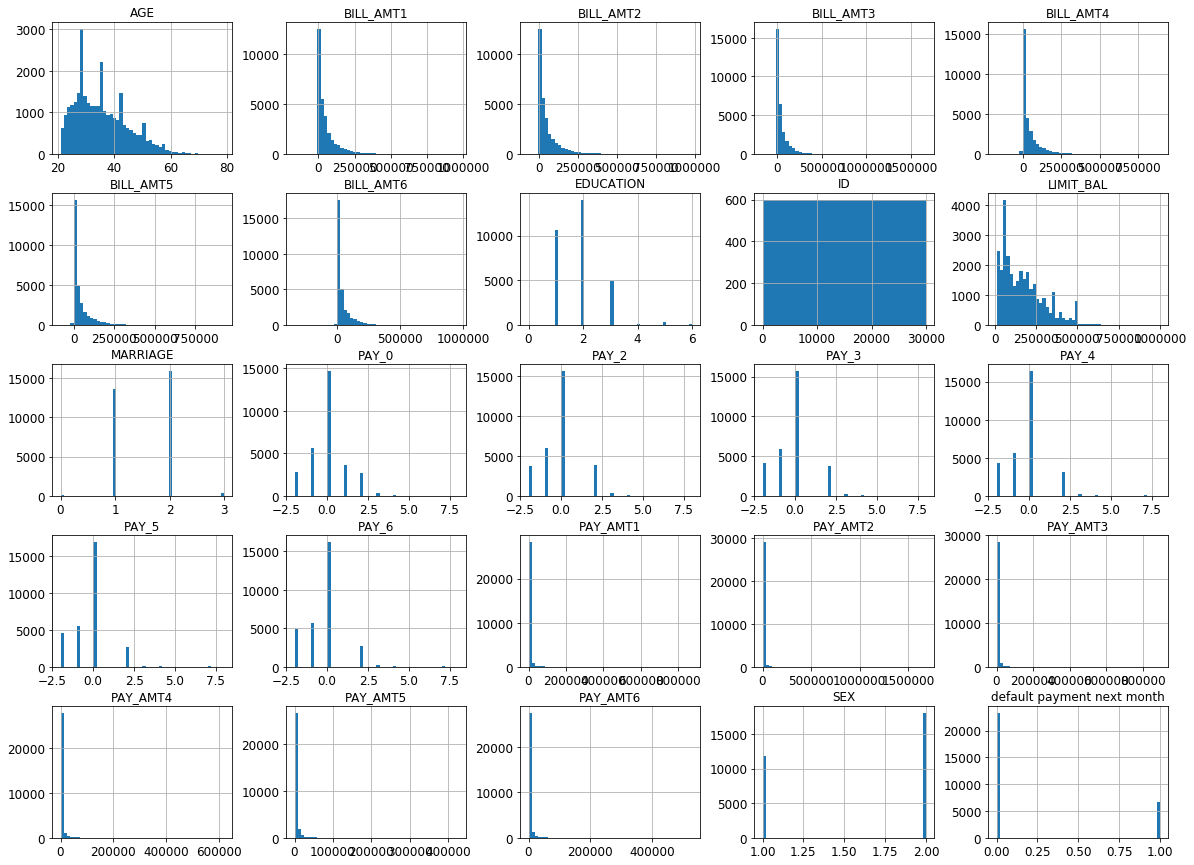

In [8]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### ID Column

The first thing that pops out is **ID** column that is just the numerical ID. This column should be dropped entirely from the feature set.

In [9]:
df = df.drop('ID', axis=1)

### Label (default payment next month)

In [10]:
df[traget_column].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

It looks like the data has far more negative cases then positive ones, we should make sure to split the train and test set so they both contain an equal balance of both.

In [11]:
def stratisfy_and_split(data, column, target, test_size = 0.2, random_date = 123):
    """
    Using sklearn's StratifiedShuffleSplit split the data into 80% train and 20% test but maintaining an equal 
    balance of the requested column.
    
    Args:
        | data: The data to be split
        | column: The column to stratisfy based on
        | target: The target column
        | test_size: The % of data to go in the rest set
        
    Returns:
        | X_train: Features for the train set
        | y_train: Labels for the train set
        | X_test: Features for the test set
        | y_test: Labels for the test set
    """
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_date)
    for train_index, test_index in split.split(data, data[column]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]

    y_train = strat_train_set[target].values
    X_train = strat_train_set.drop(target, axis=1)
    
    y_test = strat_test_set[target].values
    X_test = strat_test_set.drop(target, axis=1)
    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = stratisfy_and_split(df, traget_column, traget_column)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
print('Train ratio: {}'.format((y_train == 0).sum()/(y_train == 1).sum()))
print('Test ratio: {}'.format((y_test == 0).sum()/(y_test == 1).sum()))

Train ratio: 3.520625353173856
Test ratio: 3.5214770158251696


Let's examine the mutual information of the features

In [14]:
mi = mutual_info_classif(X_train, y_train)

<Container object of 23 artists>

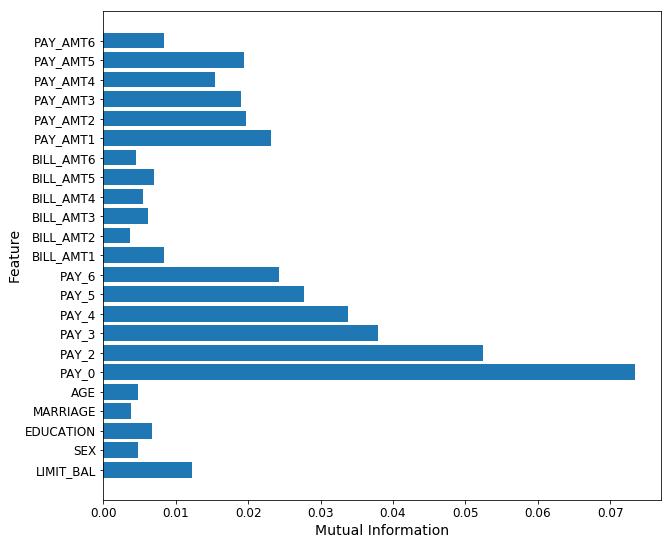

In [15]:
fig, ax = plt.subplots(figsize=(10,9))
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Feature')
ax.barh(list(range(1, len(X_train.columns)+ 1)), mi, tick_label = X_train.columns)

Looks like the features with the most mutual information are the **history of past payments** and **amount of prevous payment**. Features like *Age*, *Marriage*, and *Sex* do not seem to contain as much mutual information.

## Preprocessing Pipeline

For the preprocessing we are going to devide out features into 2 groups.

1. *Sex*, *Education*, *Marriage*, *PAY_0*, and *PAY-2*-*PAY-6* while represented as numbers are categorical so will be converted using **OneHotEncoding**.

2. The remaining columns are numeric and because we are planning to a KNN Classifier we need to scale them using **StandardScaler**. (Note: This scaling is less important for the RandomForest models).

In [16]:
encoded_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
scaled_columns = [col for col in X_train.columns if col not in encoded_columns]

In [17]:
pipeline = ColumnTransformer([
        ("scaled", StandardScaler(), scaled_columns),
        ("encoded", OneHotEncoder(categories='auto'), encoded_columns),
    ])

In [18]:
# Train the pipeline on the train data set and then transform both the train and test sets
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


### Hyperparameter Search

Below are mostly utility function for plotting and grid searching the parameter space for the RandomForestClassifier and KNNClassifiers.

**NOTE**: Accuracy label of the plot in *plot_grid_cv_results*

When we created the GridSearchCV we didn't set a scoring function. Per sklearn's documentation if you don't
set an explict scoring function it will use the score function on the estimator.

For both RandomForestClassifier and KNeighborsClassifier the default scoring is accuracy so we can put accuracy
on the labels for the plot.

(See ClassifierMixin https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py)

In [19]:
def get_predictions(model, threshold, X):
    """
    Given a model, a treshold and a set of features return the actual predicted labels.
    This would be similar to calling .predict() directly but using the specified threshold instead of 0.5.
    
    Args:
        | model: Thrained model
        | threhold: Number between 0 and 1 that will be used as a threhold for a label
        | X: Feature to predict
    Returns:
        | Predicted labels 0 or 1
    """
    predicted_probs = model.predict_proba(X)[:,1]
    predicted = np.array(predicted_probs > threshold).astype(int)
    return predicted

In [20]:
def plot_grid_cv_results(cv_results, param_name):
    """
    Takes in the cross validation results and the parameter name and plots both the mean test and the mean
    train scores for each of the parameter options. NOTE: This only works when iterating over a single parameter
    
    Args:
        | cv_results: Results from the GridSearchCV cross validation (cv_results_)
        | param_name: Name of the paramter iterated over (n_estimators for Random Forest and n_neighbors for KNN)
    """
    
    print("The Cross Validation Scores of the Grid Search over {}".format(param_name))
    mean_test_scores = [score for score in cv_results['mean_test_score']]
    mean_train_score = [score for score in cv_results['mean_train_score']]
    params = [param[param_name] for param in cv_results['params']]
    
    plt.plot(params, mean_test_scores, label='Test Score')
    plt.plot(params, mean_train_score, label='Train Score')
    plt.title('Train/Test Parameter Search Accuracy Scores')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [41]:
def plot_confusion_matrix(model, model_type, threshold, X_test, y_test):
    """
    Plots the confusion matrix for a passed in model and the provided test features and labels.
    
    Args:
        | model: Trained model
        | model_type: Type of model that was trained
        | X_test: Features for the test set
        | y_test: Labels for the test set
    """
    print('Plotting Confusion Matrix for {}:'.format(model_type))
    y_pred = get_predictions(model, threshold, X_test)
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Did Not Default', 'Defaulted']
    
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix for {} at using {} Threshold".format(model_type, threshold))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() 

In [22]:
def plot_roc_curve(model, model_type, X_train, y_train, X_test, y_test):
    """
    Plots of ROC (Receiver Operating Characteristic Curve) for a given model using sklearn's roc_curve function.
    
    Args:
        | model: Model to plot the ROC curve for
        | model_type: Name of the model
        | X_train: Features for the train set
        | y_train: Labels for the train set
        | X_test: Features for the test set
        | y_test: Labels for the test set
    """
    
    print('Plotting Receiver Operating Characteristic Curve for {}:'.format(model_type))
    
    # Test Set
    predicted = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, predicted)
    auc = roc_auc_score(y_test, predicted)
    plt.plot(fpr, tpr, linewidth=2, label='Test Set (auc = {0:.2f})'.format(auc))
    
    # Train Set
    predicted = model.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, predicted)
    auc = roc_auc_score(y_train, predicted)
    plt.plot(fpr, tpr, linewidth=2, label='Train Set (auc = {0:.2f})'.format(auc))
    
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve for {}'.format(model_type))
    plt.legend()
    plt.show()

In [23]:
def plot_precision_recall_curve(model, model_type, X_train, y_train, X_test, y_test):
    """
    Plots the Precision Recall Curve for a model for both the train and the test sets using 
    sklearns precision_recall_curve.
    
    Args:
    | model: Model to plot the ROC curve for
    | model_type: Name of the model
    | X_train: Features for the train set
    | y_train: Labels for the train set
    | X_test: Features for the test set
    | y_test: Labels for the test set
    """
    
    print("Plotting Precision Recall Curve for {}".format(model_type))
    step_kwargs = ({'step': 'post'}
           if 'step' in signature(plt.fill_between).parameters
           else {})
    
    # Test Set
    test_predicted = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test,test_predicted)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post', label='Test')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    # Train Set
    train_predicted = model.predict_proba(X_train)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_train,train_predicted)
    plt.step(recall, precision, color='y', alpha=0.2,
             where='post', label='Train')
    plt.fill_between(recall, precision, alpha=0.2, color='y', **step_kwargs)
    

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.legend()
    plt.show()

In [24]:
from IPython.display import display
def calculated_performance(model, thresholds, model_type, X_test, y_test):
    """
    Calculates the following performance metrics for the model using the provided thresholds.
    - Accuracy Score
    - Recall Score
    - Precision Score
    - F1 Score
    
    Returns the threshold and metrics for the threshold with the highest F1 Score
    
    Args:
        | model: The model to measure the performance of
        | threshold: The threshold to use to classify each element as positive or negative
        | model_type: The name of the model
        | X_test: Features for the test set
        | y_test: Labels for the test set
    """
    
    columns = ['Threshold', 'Accuracy', 'Recall', 'Precision', 'F1 Score']
    metrics = [accuracy_score, recall_score, precision_score, f1_score]
    
    scores = []
    # Loop through all the threshold and calculate the performance metrics
    for threshold in thresholds:
        test_predicted = get_predictions(model, threshold, X_test)
        scores.append([threshold] + [score_func(y_test,test_predicted) for score_func in metrics])

    performance_df = pd.DataFrame(scores, columns=columns, index=thresholds)
    display(performance_df)
    
    # Find the calculated metrics for the best F1 Score and return this
    best_accuracy = performance_df.loc[performance_df['F1 Score'].idxmax()]
    return pd.DataFrame([best_accuracy], columns=columns, index=[model_type]).T, best_accuracy['Threshold']

In [25]:
def random_forest_search(cv, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """
    Performs grid search on a RandomForestClassifier searching for the best number of estimators.
    Once the grid search completes plots the cross validation results, ROC curve, Precision Recall Curve,
    confusion matrix and displays multiple performance metrics.
    
    Args:
        | cv: Number of cross validations to run
        | X_train: Features for the train set
        | y_train: Labels for the train set
        | X_test: Features for the test set
        | y_test: Labels for the test set
    Returns:
        | DataFrame of Performance metrics
    """
    
    model_type = "RandomForestClassifier"
    
    # Perform grid search on the alpha range
    param_grid = [{'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100] }]
    random_forest = RandomForestClassifier(random_state=123)
    grid_search = GridSearchCV(random_forest, param_grid, cv=cv,
                               return_train_score=True, n_jobs =-1)
    
    grid_search.fit(X_train, y_train)
    
    print('The best parameter for n_estimators was: {}'.format(grid_search.best_params_))
    
    plot_grid_cv_results(grid_search.cv_results_, 'n_estimators')
    plot_roc_curve(grid_search.best_estimator_, model_type, X_train, y_train, X_test, y_test)
    plot_precision_recall_curve(grid_search.best_estimator_, model_type, X_train, y_train, X_test, y_test)
    
    
    # Alternatively Get the threhold from the user
    # threshold = input("What threshold would you like to use?")
    performance, threshold = calculated_performance(grid_search.best_estimator_, 
                                                 [0.2, 0.4, 0.5, 0.6, 0.8], 
                                                 model_type, 
                                                 X_test, 
                                                 y_test)

    plot_confusion_matrix(grid_search.best_estimator_, model_type, threshold, X_test, y_test)  
    return performance

In [26]:
def knn_search(cv, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """
    Performs grid search on a KNN Classifier searching for the best number of nearest neighbours.
    Once the grid search completes plots the cross validation results, ROC curve, Precision Recall Curve,
    confusion matrix and displays multiple performance metrics.
    
    Args:
        | cv: Number of cross validations to run
        | X_train: Features for the train set
        | y_train: Labels for the train set
        | X_test: Features for the test set
    Returns:
        | DataFrame of Performance metrics
    """
    model_type = "KNN Classifier"
    
    # Perform grid search on the alpha range
    param_grid = [{'n_neighbors': [3, 4, 5, 7, 10, 20, 50] }]
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=cv,
                               return_train_score=True, n_jobs =-1)
    
    grid_search.fit(X_train, y_train)
    
    print('The best parameter for n_estimators was: {}'.format(grid_search.best_params_))
    
    plot_grid_cv_results(grid_search.cv_results_, 'n_neighbors')
    plot_roc_curve(grid_search.best_estimator_, model_type, X_train, y_train, X_test, y_test)
    plot_precision_recall_curve(grid_search.best_estimator_, model_type, X_train, y_train, X_test, y_test)
    # Alternatively Get the threhold from the user
    # threshold = input("What threshold would you like to use?")
    performance, threshold = calculated_performance(grid_search.best_estimator_, 
                                                 [0.2, 0.4, 0.5, 0.6, 0.8], 
                                                 model_type, 
                                                 X_test, 
                                                 y_test)

    plot_confusion_matrix(grid_search.best_estimator_, model_type, threshold, X_test, y_test)  
    return performance

The best parameter for n_estimators was: {'n_estimators': 100}
The Cross Validation Scores of the Grid Search over n_estimators


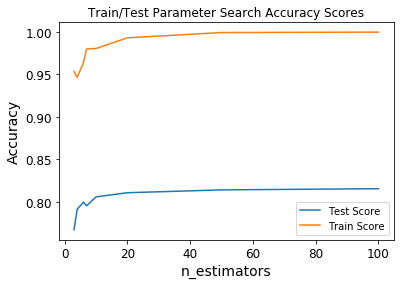

Plotting Receiver Operating Characteristic Curve for RandomForestClassifier:


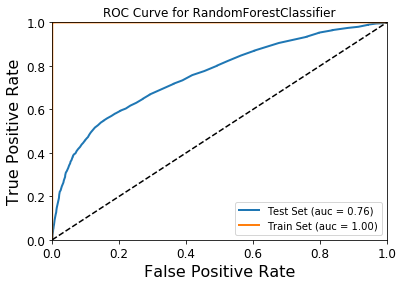

Plotting Precision Recall Curve for RandomForestClassifier


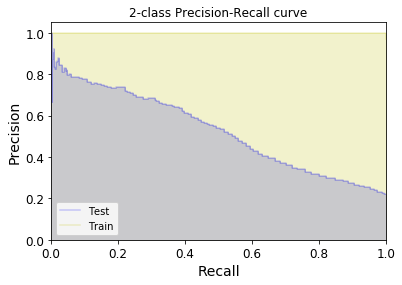

,Threshold,Accuracy,Recall,Precision,F1 Score
0.2,0.2,0.685000,0.684250,0.381673,0.490016
0.4,0.4,0.805333,0.446119,0.577561,0.503401
0.5,0.5,0.815667,0.359457,0.650750,0.463107
0.6,0.6,0.811000,0.262999,0.691089,0.381004
0.8,0.8,0.788833,0.060286,0.800000,0.112123


Plotting Confusion Matrix for RandomForestClassifier:


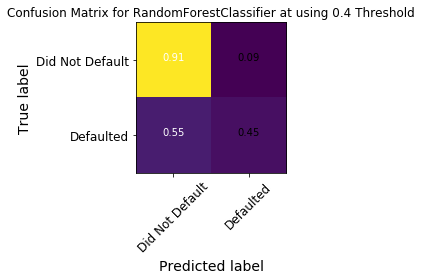

In [42]:
forest_4_cv = random_forest_search(4)

The best parameter for n_estimators was: {'n_neighbors': 50}
The Cross Validation Scores of the Grid Search over n_neighbors


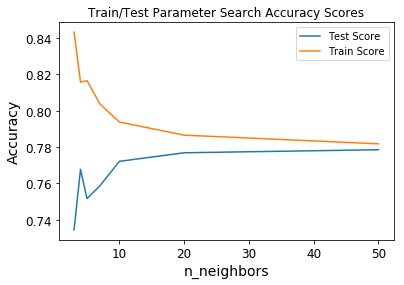

Plotting Receiver Operating Characteristic Curve for KNN Classifier:


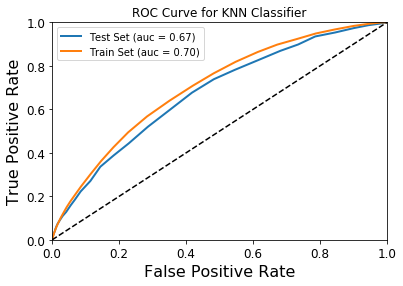

Plotting Precision Recall Curve for KNN Classifier


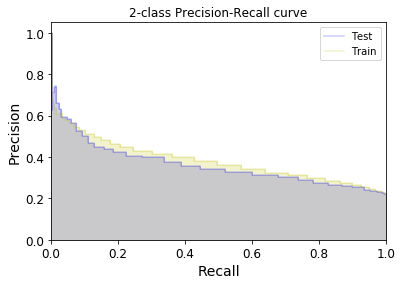

/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Threshold,Accuracy,Recall,Precision,F1 Score
0.2,0.2,0.566167,0.738508,0.302843,0.429542
0.4,0.4,0.771000,0.158252,0.449679,0.234114
0.5,0.5,0.782667,0.059533,0.585185,0.108071
0.6,0.6,0.781000,0.015072,0.740741,0.029542
0.8,0.8,0.778833,0.000000,0.000000,0.000000


Plotting Confusion Matrix for KNN Classifier:


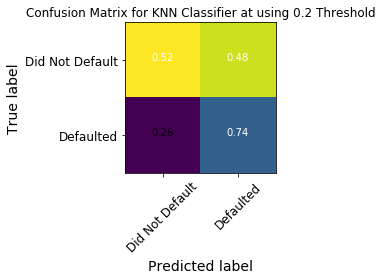

In [43]:
knn_4_cv = knn_search(4)

- Cross-validation with 5-folds
#Did you get different results compared to the 4-fold case?

The best parameter for n_estimators was: {'n_estimators': 100}
The Cross Validation Scores of the Grid Search over n_estimators


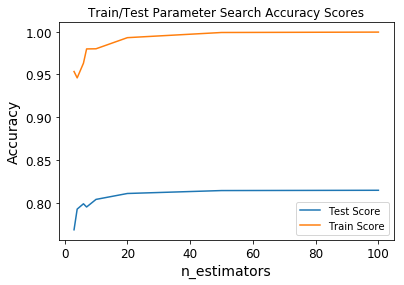

Plotting Receiver Operating Characteristic Curve for RandomForestClassifier:


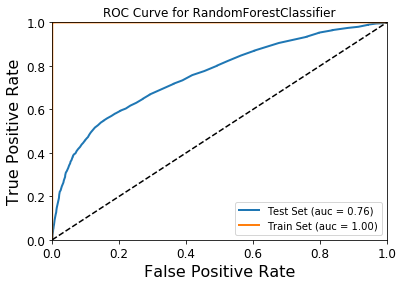

Plotting Precision Recall Curve for RandomForestClassifier


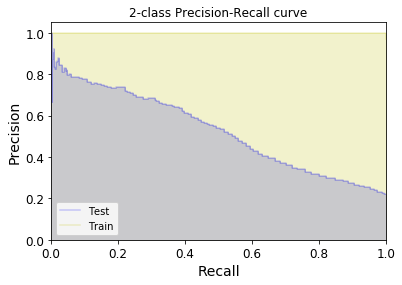

,Threshold,Accuracy,Recall,Precision,F1 Score
0.2,0.2,0.685000,0.684250,0.381673,0.490016
0.4,0.4,0.805333,0.446119,0.577561,0.503401
0.5,0.5,0.815667,0.359457,0.650750,0.463107
0.6,0.6,0.811000,0.262999,0.691089,0.381004
0.8,0.8,0.788833,0.060286,0.800000,0.112123


Plotting Confusion Matrix for RandomForestClassifier:


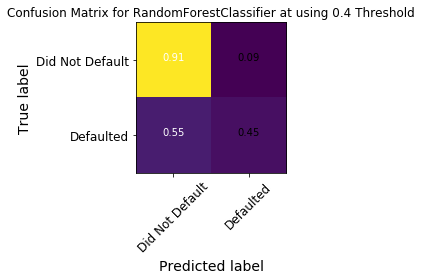

In [44]:
forest_5_cv = random_forest_search(5)

The best parameter for n_estimators was: {'n_neighbors': 50}
The Cross Validation Scores of the Grid Search over n_neighbors


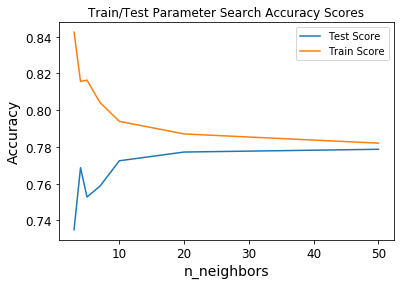

Plotting Receiver Operating Characteristic Curve for KNN Classifier:


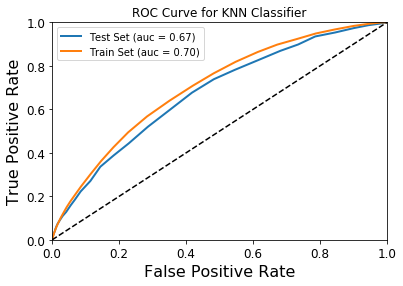

Plotting Precision Recall Curve for KNN Classifier


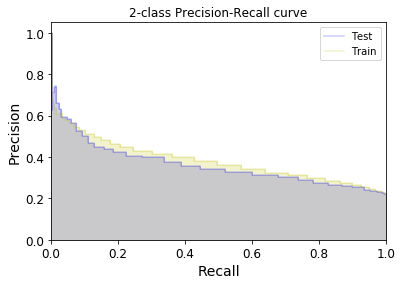

/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Threshold,Accuracy,Recall,Precision,F1 Score
0.2,0.2,0.566167,0.738508,0.302843,0.429542
0.4,0.4,0.771000,0.158252,0.449679,0.234114
0.5,0.5,0.782667,0.059533,0.585185,0.108071
0.6,0.6,0.781000,0.015072,0.740741,0.029542
0.8,0.8,0.778833,0.000000,0.000000,0.000000


Plotting Confusion Matrix for KNN Classifier:


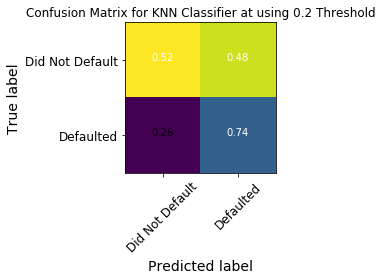

In [45]:
knn_5_cv = knn_search(5)

In [46]:
forest_4_cv, forest_5_cv, knn_4_cv, knn_5_cv
forest_4_cv.columns = ['Random Forest Classifier 4 Fold']
forest_5_cv.columns = ['Random Forest Classifier 5 Fold']
knn_4_cv.columns = ['KNN Classifier 4 Fold']
knn_5_cv.columns = ['KNN Classifier 5 Fold']
pd.concat([forest_4_cv, forest_5_cv, knn_4_cv, knn_5_cv], sort=False, axis=1)

,Random Forest Classifier 4 Fold,Random Forest Classifier 5 Fold,KNN Classifier 4 Fold,KNN Classifier 5 Fold
Threshold,0.400000,0.400000,0.200000,0.200000
Accuracy,0.805333,0.805333,0.566167,0.566167
Recall,0.446119,0.446119,0.738508,0.738508
Precision,0.577561,0.577561,0.302843,0.302843
F1 Score,0.503401,0.503401,0.429542,0.429542


#### Conclusions?

Explain your results and choices

### Random Forest Classifier Observations

#### Number of Trees:
Both the test and the train scores increased as the number of trees did with the train score plateauing at 1 (100% accuracy) and the test score plateauing a little over 80%.

The resulting best parameters had a number of trees of **100**. 

Since 100 was the most we had in our grid search it’s possible we could have gotten a better test performance with a higher number of trees but we may also end up overfitting to the training data.

##### ROC Curve:

The ROC curve on the train set had a perfect area under the curve of 1, indicating the model fit very well to the train data, unsurprisingly for a RandomForestClassifier. It had an area under the curve of 0.76 which is much better than random.

It also shows for the training data before a fpr of 0.2 the tpr rate raises quite quickly but slows down after that point.

##### Precision Recall Curve:

In a similar trend the precision recall curve for the training data shows a near perfect 100% precision across all recalls levels. While the training set shows high precision (80-90%) for lower recalls teetering off to around 20% for higher recalls.


##### Performance Metrics:

The model's metrics varried greatly depending on the selected threshold.

For the default 0.5 the model got an impressive accuracy of 81.6% but a much less impressive recall of 39.5% and precision of 65.1%.

For the different thresholds the accuracy didn't change too much (lowest 68% at 0.2 and the highest 81.6% at 0.5).

Picking the treshold would depend on the goal of the model.

If we wanted to be very sure we could catch everyone who defaulted we could set the threshold to a higher value ~0.8 where the model had a precision of 80% but we would also wrongly label people who likely won't default as likely defaulting.

If we want to be very sure the people we flag will default we could set the threshold to 0.2 and end up with a 68% recall but some people who might default may slip through the cracks.

The threshold with the best F-Value was **0.4**.

##### Confusion Matrix:

The confusion matrix was creating using the 0.4 threshold. It showed the model was decent at predicting that the people who did not actually default would not default. However it wasn’t very good correctly predicting people who did default.


### KNN Classifier Observations

Number of neighbours:

As the number of neighbours increased the training accuracy dropped while the testing accuracy increased. This makes logical sense as the model was fit with the training points so the best number of neighbours would have been 1 and adding any more neighbours would just decrease the training error.

The best parameter had a number of neighbours again at the maximum number of **50**.

##### ROC Curve:

Here the KNNClassifier shows slightly different results than the RandomForestClassifer in a couple of ways.

The auc for the training set this time was only and both the test and train auc were fairly similar 0.67 vs 0.70.

Overall the auc for the test set as well was much lower for the KNNClassifier compared to the RandomForestClassifier (0.67 vs 0.76).

##### Precision Recall Curve:

Again unlike the RandomForestModel here both the training and test sets show a similar precision recall curve.

Even at lower recall the maximum achieved precision is only 70-80%. At the the highest recall a precision of ~20% is seen which is similar to the RandomForestClassifier.


##### Prediction Metrics:

The KNN Model did get a maximum relatively impressive 78.2% accuracy score but that was likely due to most of the data being negative. For this accuracy the precision was 58.5% and the recall was 5.9.

The best F-Score occured using a threshold of .2.


##### Confusion Matrix:

The confusion matrix was plotted for the threshold of 0.2 and shows at this threshold there were nearly as many false negative's as there were true negatives. The model was a little better at predicting true positives but still only carrectly classified 74% of the cases who did default as would default even with an incredible low threshold.

### Head to Head Comparision

With the current feature set neither model performed outstandingly. Overall the RandomForestClassifier did outperformed the KNNClassifier in our measured metrics.

Some possible improvements:
- Engineering new features
- Dropping features that are just considered noise with a mutual information threshold
- In addition to stratify the data based on the label additional stratisfy on other important features like history of past payments

### 4 Fold  vs 5 Fold Cross Validaton

Running the GridSearch with 4 folds of cross validation compared to 5 folds did not seem to have a big impact. Both the RandomForestClassifier and the KNNClassifier ending up picking the same optimized parameter set for both runs so the resulting models had the same performance.

It is somewhat difficult to see on the accuracy plots for the parameter search but the 5 Fold Cross validation did have very slightly high average accuracy than the 4 fold.

Q2. (Optional) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion. 

In [32]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
mnist = fetch_mldata('MNIST original')

/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/cindylopes/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
def shift_image(original, direction):
    """
    Takes an image (784 length array representing a 28x28 image) and a direction (left, right, up, down)
    and create a new image shifting the original image 1 pixel in the desired direction.
    
    Args:
        | original: Original 784 pixels
        | direction: Direct to shift the image
    Returns:
        | New 784 array image with the shifted pixels
    """
    image = original.reshape(28, 28)
    
    if direction is 'down':
        # Add a row of zeros to the top of the image and remove the last row
        black_row = np.zeros(28)
        image = np.vstack([black_row, image])
        image = image[0:-1]
    elif direction is 'up':
        # Add a row of zeros to the bottom of the image and remove the last row
        black_row = np.zeros(28)
        image = np.vstack([image, black_row])
        image = image[1:]
    elif direction is 'right':
        # Insert a 0 at the start of all the rows and remove the last element of all the rows
        image = np.insert(image, 0, 0, axis=1)
        image = image[:,:-1]
    elif direction is 'left':
        # Insert a 0 at the end of lal the rows and remove the first element of all the rows
        image = np.insert(image, image.shape[0], 0, axis=1)
        image = image[:,1:]
        
    return image.ravel()

def create_augmented_images(all_images, labels):
    """
    Takes a list of images and for each image creates 4 other images each being shifted 1 pixel either up, down, left
    or right.
    
    Also takes in a list of labels and create a new list of labels.
    
    Args:
        | all_images: 2d Numpy matrix of all the images to shift
    Returns:
        | A new 2d numpy matrix will the original and shifted images along with the new labels
    """
    new_images = []
    new_labels = []
    for image, label in zip(all_images, labels):    
        new_images.append(image)
        new_labels.append(label)
        
        directions = ['left','right','up', 'down']
        for direction in directions:
            transformed_image = shift_image(image, direction)
            new_images.append(transformed_image)
            new_labels.append(label)

    return np.vstack(new_images), new_labels

Load the MNIST data set and using a GridSearch train a RandomForestModel

In [34]:
X, y = mnist["data"], mnist["target"]
print(X.shape)

# Split the original non-augmented data into test and train
shuffle_index = np.random.permutation(60000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Using grid search find the optimal number of estimators
param_grid = [{'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100] }]
model = RandomForestClassifier(random_state=123)
grid_search = GridSearchCV(model, param_grid, cv=5,
                           return_train_score=True, n_jobs =-1)
grid_search.fit(X_train, y_train)

print('The best parameter was: {}'.format(grid_search.best_params_))

best_model = grid_search.best_estimator_

# Using the best model predict the outcomes for the test set and then display the performance metrics
predictions = best_model.predict(X_test)
accuracy_score(y_test, predictions)
print('Accuracy of model trained on non-augmented data {}'.format(accuracy_score(y_test, predictions)))

(70000, 784)
The best parameter was: {'n_estimators': 100}
Accuracy of model trained on non-augmented data 0.9703


### Augmented Dataset

For each of the images in the training dataset create 4 new images by shifted each image 1 pixel to the left, right, top and bottom to get 4 new images + the original image.

In [35]:
augmented_images, augmented_labels = create_augmented_images(X_train, y_train)
augmented_images.shape, len(augmented_labels)

((300000, 784), 300000)

Train another Random Forest Model on the augmented data set then see how it performs on the same test set as the prevoius RandomForstModel

In [36]:
augmented_model = RandomForestClassifier(n_estimators=100, random_state=123)
augmented_model.fit(augmented_images, augmented_labels)

# Again have the trained model make predictions on the un-altered test set
predictions = augmented_model.predict(X_test)
print('Accuracy of model trained on augmented data {}'.format(accuracy_score(y_test, predictions)))

Accuracy of model trained on augmented data 0.9803


### Conclusions


It appears, as expected, training on the augmented dataset did increase the accuracy from ~97% to slightly above ~98%.

Logically this makes sense since the model is just learning the sequence of pixels without any 2d knowledge, with this new training data the model should better be able to predict hand written numbers that looked similar to a image in the training set but may not have been centered exactly the same.